In [71]:
import os
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from run_gradient_em_attack import run_attack

In [2]:
main_folder = 'output/'
german_json_folder = os.path.join(main_folder, 'german', 'influence_data')
compas_json_folder = os.path.join(main_folder, 'compas', 'influence_data')
drug_json_folder = os.path.join(main_folder, 'drug',   'influence_data')

# Effect of epsilon on the different metrics

This section of the notebook reproduces Figure 2 of the original paper. We investigate the influence of epsilon on the different metrics (test error, statistical parity difference, equality of opportunity difference) and compare the results obtained using two different stopping criteria: parity and accuracy.

## Loading the pre-trained models
The next cell imports the required models, which have already been pre-trained. They are evaluated on the indicated dataset, and the results are stored.

*Note: this might take ~10 min.*

In [119]:
%%capture

results_parity = {}
results_accuracy = {}

datasets = ["german", "compas", "drug"]
attacks  = ["IAF", "NRAA", "RAA", "Koh", "Solans"]
epsilon = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for dataset in datasets:

    # Each dictionary contains the datasets as keys. The value of these keys is another dictionary,
    # where they keys are the different attacks. They will store the values of the different metrics
    results_parity[dataset]   = {attack: {} for attack in attacks}
    results_accuracy[dataset] = {attack: {} for attack in attacks}

    for attack in attacks:

        for eps in epsilon:

            # Retrieve results
            log_parity   = run_attack(total_grad_iter = 10000, dataset = dataset, use_slab = True, epsilon = eps, lamb = 1, method = attack, stopping_method = "Parity",   stop_after = 2, eval_mode = True)
            log_accuracy = run_attack(total_grad_iter = 10000, dataset = dataset, use_slab = True, epsilon = eps, lamb = 1, method = attack, stopping_method = "Accuracy", stop_after = 2, eval_mode = True)

            # Store results using Parity as the stopping method
            results_parity[dataset][attack].setdefault("test_error", []).append(1 - log_parity['test_acc'])
            results_parity[dataset][attack].setdefault("SPD", []).append(log_parity['Parity'])
            results_parity[dataset][attack].setdefault("EOD", []).append(log_parity['E0'])

            # Store results using Accuracy as the stopping method
            results_accuracy[dataset][attack].setdefault("test_error", []).append(1 - log_accuracy['test_acc'])
            results_accuracy[dataset][attack].setdefault("SPD", []).append(log_accuracy['Parity'])
            results_accuracy[dataset][attack].setdefault("EOD", []).append(log_accuracy['E0'])


INFO:tensorflow:Restoring parameters from output/german/influence_data/german_no_attack-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_no_attack-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_IAF_0.1_1.0_Parity-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_IAF_0.1_1.0_Accuracy-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_IAF_0.2_1.0_Parity-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_IAF_0.2_1.0_Accuracy-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_IAF_0.3_1.0_Parity-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_IAF_0.3_1.0_Accuracy-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_IAF_0.4_1.0_Parity-checkpoint
INFO:tensorflow:Restoring parameters fro

ValueError: The passed save_path is not a valid checkpoint: output/compas/influence_data/compas_NRAA_0.2_1.0_Accuracy-checkpoint

## Generating figure (Stopping Metric: Parity)

ValueError: x and y must have same first dimension, but have shapes (11,) and (1,)

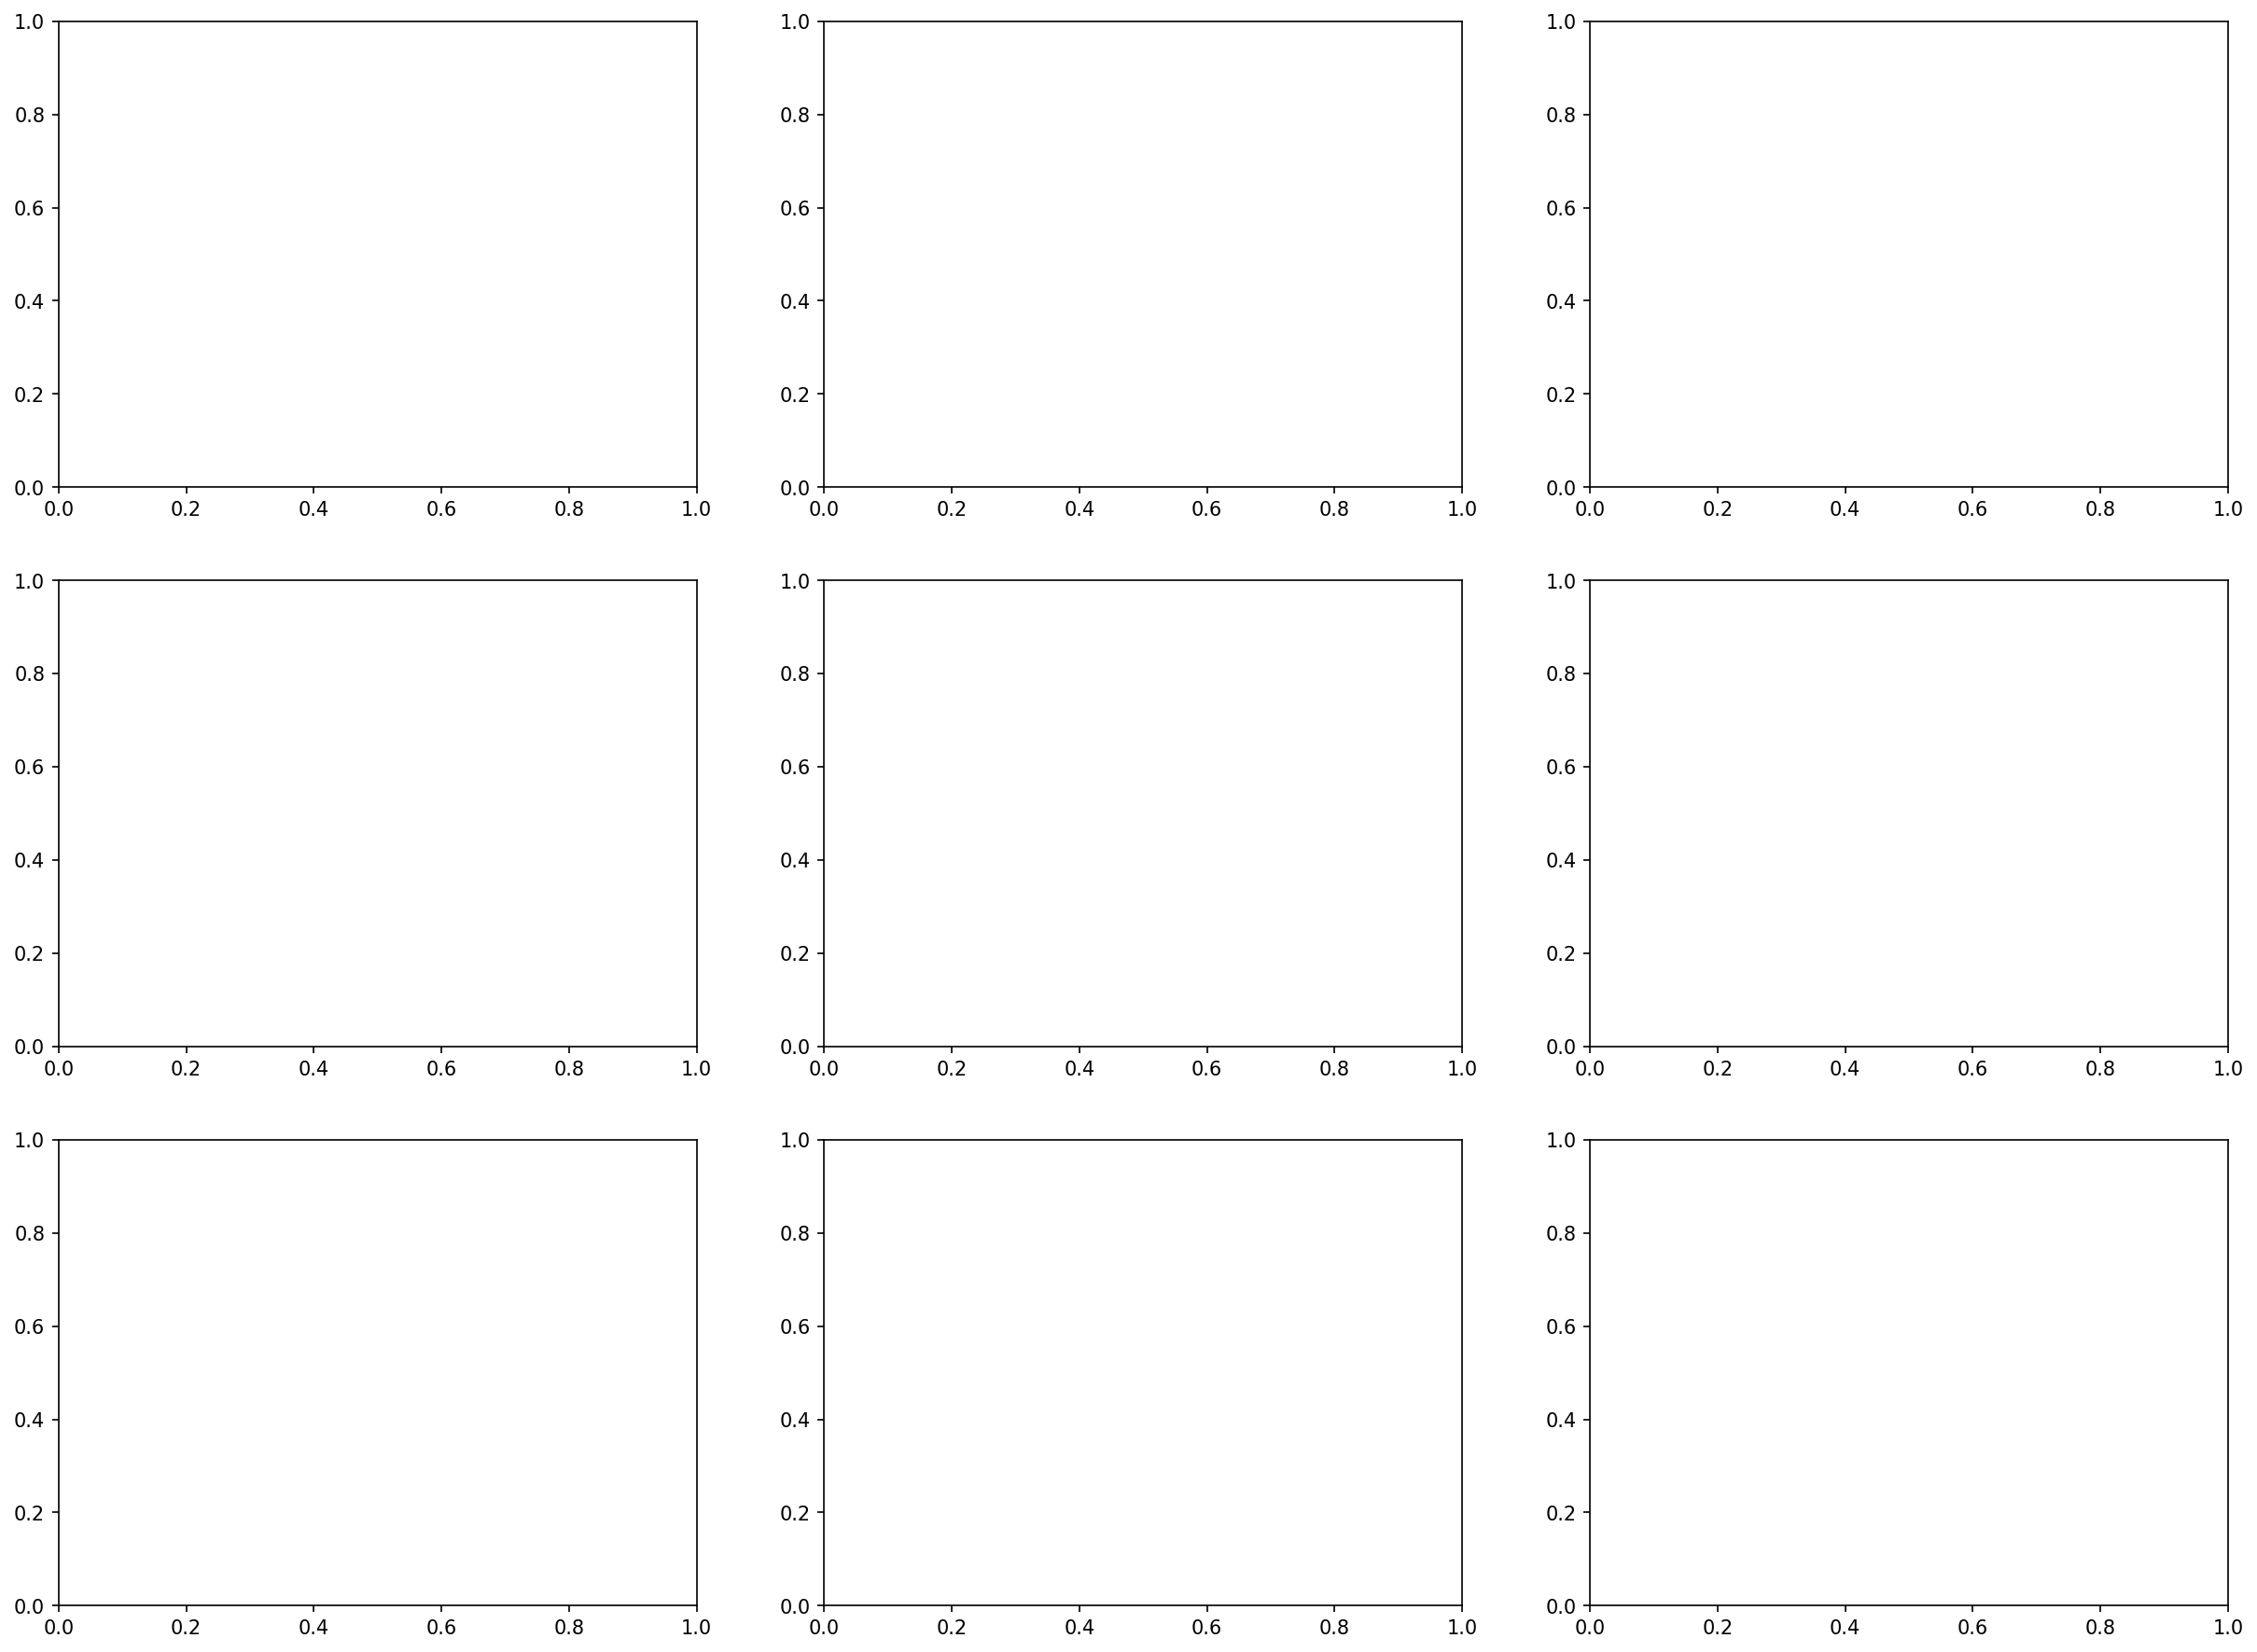

In [115]:
colors  = ['b', 'r', 'g', 'm', 'tab:orange']
markers = ['s', 'X', matplotlib.markers.CARETDOWNBASE, 'o', '*']

## Generating Figure 2 using PARITY as the stopping method
fig, axs = plt.subplots(3, 3, figsize=(20,15), dpi=150)
rows = [0,1,2]
cols = [0,1,2]
for row in rows:
    # Choose dataset based on the row
    if row == 0:
        dataset = 'german'
    elif row==1:
        dataset = 'compas'
    else:
        dataset = 'drug'
    
    for col in cols:
        # Choose metric to plot based on the column
        if col == 0:
            metric = 'test_error'
            y_label = 'Test Error'
        elif col==1:
            metric = 'SPD'
            y_label = 'Statistical Parity Difference (SPD)'
        else:
            metric = 'EOD'
            y_label = 'Equality of Opportunity Difference (EOD)'

        for att, c, m in zip(attacks, colors, markers):
            axs[row, col].plot(epsilon, results_parity[dataset][att][metric], label=att, color = c, marker = m)
            axs[row, col].legend(ncol=2)
            axs[row, col].set_ylim([0, 1.15])
            axs[row, col].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
            axs[row, col].grid(alpha=0.25)
            axs[row, col].title.set_text(f'{dataset.capitalize()} Dataset')
            axs[row, col].set_xlabel('Epsilon ($\epsilon$)')
            axs[row, col].set_ylabel(y_label)


fig.suptitle('Stopping metric: parity\n', fontsize=16, fontweight='bold')
fig.tight_layout()

## Generating figure (Stopping Metric: Accuracy)

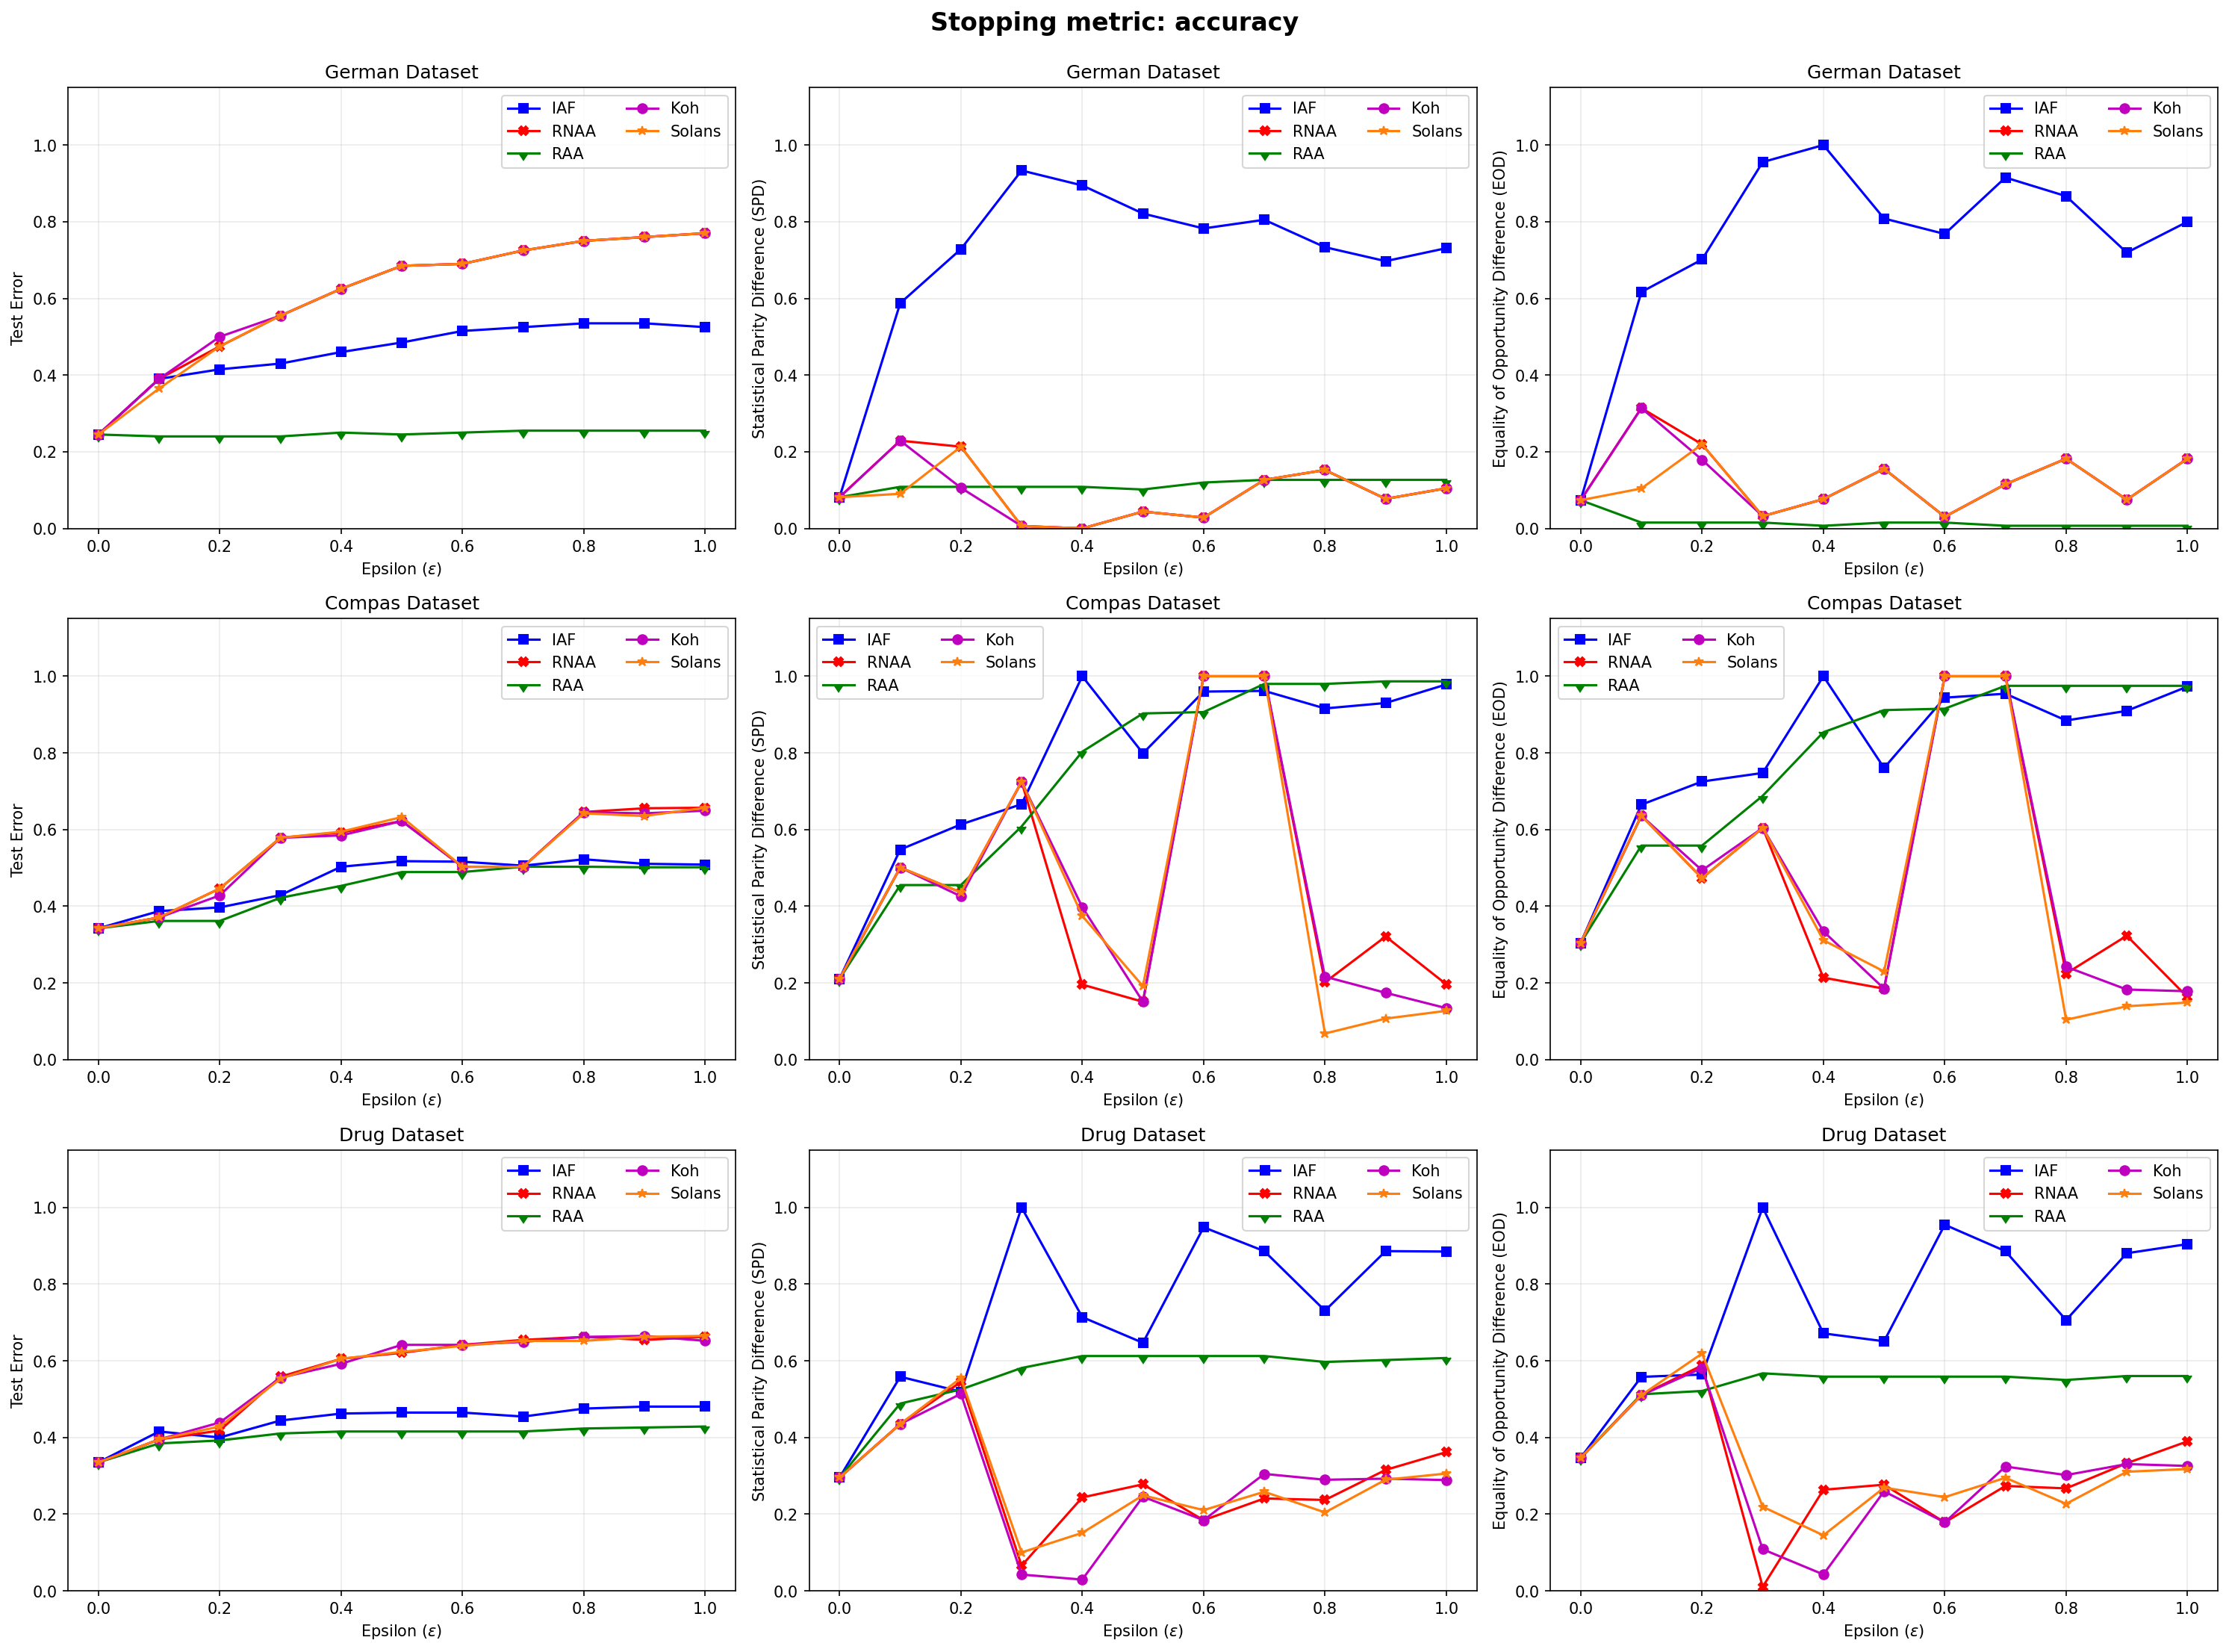

In [113]:
## Generating Figure 2 using ACCURACY as the stopping method
fig, axs = plt.subplots(3, 3, figsize=(20,15), dpi=150)
rows = [0,1,2]
cols = [0,1,2]
for row in rows:
    # Choose dataset based on the row
    if row == 0:
        dataset = 'german'
    elif row==1:
        dataset = 'compas'
    else:
        dataset = 'drug'
    
    for col in cols:
        # Choose metric to plot based on the column
        if col == 0:
            metric = 'test_error'
            y_label = 'Test Error'
        elif col==1:
            metric = 'SPD'
            y_label = 'Statistical Parity Difference (SPD)'
        else:
            metric = 'EOD'
            y_label = 'Equality of Opportunity Difference (EOD)'

        for att, c, m in zip(attacks, colors, markers):
            axs[row, col].plot(epsilon, results_accuracy[dataset][att][metric], label=att, color = c, marker = m)
            axs[row, col].legend(ncol=2)
            axs[row, col].set_ylim([0, 1.15])
            axs[row, col].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
            axs[row, col].grid(alpha=0.25)
            axs[row, col].title.set_text(f'{dataset.capitalize()} Dataset')
            axs[row, col].set_xlabel('Epsilon ($\epsilon$)')
            axs[row, col].set_ylabel(y_label)


fig.suptitle('Stopping metric: accuracy\n', fontsize=16, fontweight='bold')
fig.tight_layout()

# Effect of lambda on the different metrics

This section of the notebook reproduces Figure 3 of the original paper. We investigate the influence of lambda on the different metrics (test error, statistical parity difference, equality of opportunity difference) for different epsilons. Again, we compare the results obtained using two different stopping criteria: parity and accuracy.

In [120]:
%%capture

results_parity = {}
results_accuracy = {}

datasets = ["german", "compas", "drug"]
lambdas = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
epsilons = [0.0, 0.1, 0.5, 1.0]

for dataset in datasets:

    # Each dictionary contains epsilon as keys
    results_parity[dataset]   = {epsilon: {} for epsilon in epsilons}
    results_accuracy[dataset] = {epsilon: {} for epsilon in epsilons}

    for eps in epsilons:

        for lamb in lambdas:

            # Retrieve results
            log_parity   = run_attack(total_grad_iter = 10000, dataset = dataset, use_slab = True, epsilon = eps, lamb = lamb, method = "IAF", stopping_method = "Parity",   stop_after = 2, log_metrics = True, display_iter_time = True, eval_mode = True)
            log_accuracy = run_attack(total_grad_iter = 10000, dataset = dataset, use_slab = True, epsilon = eps, lamb = lamb, method = "IAF", stopping_method = "Accuracy", stop_after = 2, log_metrics = True, display_iter_time = True, eval_mode = True)

            # Store results using Parity as the stopping method
            results_parity[dataset][eps].setdefault("test_error", []).append(1 - log_parity['test_acc'])
            results_parity[dataset][eps].setdefault("SPD", []).append(log_parity['Parity'])
            results_parity[dataset][eps].setdefault("EOD", []).append(log_parity['E0'])

            # Store results using Accuracy as the stopping method
            results_accuracy[dataset][eps].setdefault("test_error", []).append(1 - log_accuracy['test_acc'])
            results_accuracy[dataset][eps].setdefault("SPD", []).append(log_accuracy['Parity'])
            results_accuracy[dataset][eps].setdefault("EOD", []).append(log_accuracy['E0'])


INFO:tensorflow:Restoring parameters from output/german/influence_data/german_no_attack-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_no_attack-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_no_attack-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_no_attack-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_no_attack-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_no_attack-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_no_attack-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_no_attack-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_no_attack-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_no_attack-checkpoint
INFO:tenso

ValueError: The passed save_path is not a valid checkpoint: output/german/influence_data/german_IAF_1.0_0.0_Accuracy-checkpoint

## Generating figure (Stopping Metric: Parity)

In [ ]:
colors  = ['tab:orange', 'b', 'r', 'g']
markers = ['*', 's', 'X', matplotlib.markers.CARETDOWNBASE]

## Generating Figure 2 using PARITY as the stopping method
fig, axs = plt.subplots(3, 3, figsize=(20,15), dpi=150)
rows = [0,1,2]
cols = [0,1,2]
for row in rows:
    # Choose dataset based on the row
    if row == 0:
        dataset = 'german'
    elif row==1:
        dataset = 'compas'
    else:
        dataset = 'drug'
    
    for col in cols:
        # Choose metric to plot based on the column
        if col == 0:
            metric = 'test_error'
            y_label = 'Test Error'
        elif col==1:
            metric = 'SPD'
            y_label = 'Statistical Parity Difference (SPD)'
        else:
            metric = 'EOD'
            y_label = 'Equality of Opportunity Difference (EOD)'

        for att, c, m in zip(attacks, colors, markers):
            axs[row, col].plot(, results_parity[dataset][att][metric], label=att, color = c, marker = m)
            axs[row, col].legend(ncol=2)
            axs[row, col].set_ylim([0, 1.15])
            axs[row, col].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
            axs[row, col].grid(alpha=0.25)
            axs[row, col].title.set_text(f'{dataset.capitalize()} Dataset')
            axs[row, col].set_xlabel('Epsilon ($\epsilon$)')
            axs[row, col].set_ylabel(y_label)


fig.suptitle('Stopping metric: parity\n', fontsize=16, fontweight='bold')
fig.tight_layout()

## Generating figure (Stopping Metric: Accuracy)

In [ ]:
f_german_solans = open(os.path.join(german_json_folder, 'german_Solans_0.5_1.0_Accuracy-checkpoint.json'))

# Study of the accuracy/parity trade-off 
In this section we present results that extend Mehrabi et al's work. We study the trade-off between accuracy and fairness introduced by the term lambda, for representative attacks and datasets.

## Load models

In [186]:
# Accuracy/Parity tradeoff depending on the epoch, for Accuracy based stopper, Solans attack, COMPAS dataset
f_german_solans = open(os.path.join(german_json_folder, 'german_Solans_0.5_1.0_Accuracy-checkpoint.json'))
german_solans = json.load(f_german_solans)

# Accuracy/Parity tradeoff depending on the epoch, for Parity based stopper, Solans attack, COMPAS dataset
f_compas_solans = open(os.path.join(compas_json_folder, 'compas_Solans_0.5_1.0_Parity-checkpoint.json'))
compas_solans = json.load(f_compas_solans)

## Generate plots

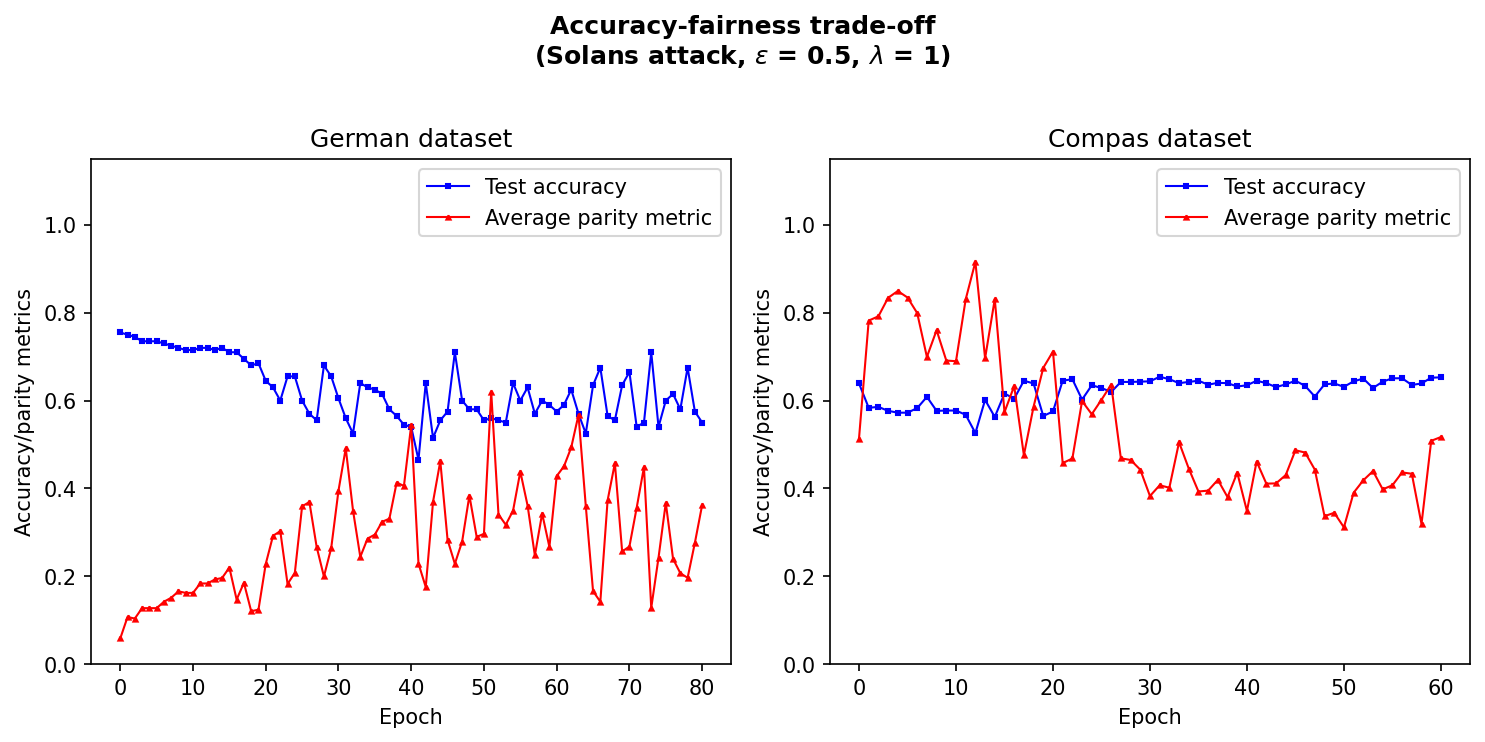

In [188]:
# First plot
fig, axs = plt.subplots(1, 2, figsize=(10,5), dpi=150)
axs[0].set_title('German dataset')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy/parity metrics')
axs[0].plot(german_solans['Accuracies'], label='Test accuracy', color = 'b', linewidth = 1, ms = 1.5, marker = 's')
axs[0].plot(german_solans['Average_Parities'], label='Average parity metric', color = 'r', linewidth = 1, ms = 2, marker = '^')
axs[0].set_ylim([0, 1.15])
#axs[0].set_xlim([-2, 64])
axs[0].legend()

# Second plot
axs[1].set_title('Compas dataset')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy/parity metrics')
axs[1].plot(compas_solans['Accuracies'], label='Test accuracy', color = 'b', linewidth = 1, ms = 1.5, marker = 's')
axs[1].plot(compas_solans['Average_Parities'], label='Average parity metric', color = 'r', linewidth = 1, ms = 2, marker = '^')
axs[1].set_ylim([0, 1.15])

axs[1].legend()

fig.suptitle('Accuracy-fairness trade-off\n(Solans attack, $\epsilon$ = 0.5, $\lambda$ = 1)\n', fontweight = 'bold')
fig.tight_layout()

## Analysis
At the epoch with minimal accuracy, what is the value of the parity? What can be the actual maximal value of the parity?

In [185]:
# -- Get relevant stats of the run with the german dataset
min_acc_idx_german = int(np.where(german_solans['Accuracies']==np.min(german_solans['Accuracies']))[0])
parity_at_min_acc_german = german_solans['Average_Parities'][min_acc_idx_german]
# -- Get relevant stats of the run with the compas dataset
min_acc_idx_compas = int(np.where(compas_solans['Accuracies']==np.min(compas_solans['Accuracies']))[0])
parity_at_min_acc_compas = compas_solans['Average_Parities'][min_acc_idx_compas]

# Print info
print("{:>45} {:>10} {:>10}".format(" ", "German", "Compas"))
print("{:>45} {:>10.3f} {:>10.3f}".format("Minimum accuracy:", np.min(german_solans['Accuracies']), np.min(compas_solans['Accuracies'])))
print("{:>45} {:>10.3f} {:>10.3f}".format("Parity at the point of minimum accuracy:", parity_at_min_acc_german, parity_at_min_acc_compas))
print("{:>45} {:>10.3f} {:>10.3f}".format("Actual maximal parity:", np.max(german_solans['Average_Parities']), np.max(compas_solans['Average_Parities'])))


                                                  German     Compas
                            Minimum accuracy:      0.465      0.526
     Parity at the point of minimum accuracy:      0.229      0.916
                       Actual maximal parity:      0.619      0.916
